<a href="https://colab.research.google.com/github/ClaytonCarvalho/MVP.v1-Clayton_Carvalho/blob/main/MVP2_Final_Clayton_Carvalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MVP-PARTE1
**Objetivo:** Verificar a confiabilidade do índice de retorno para calcular o percentual de retorno por faixa etária de uma base que contem apenas pacientes que já efetuaram internações e tiveram passagem pelo pronto socorro no período de 6 meses.

In [49]:
 #Importação das bibliotecas:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import f_regression

#Importação e tratamento dos dados

Nessa etapa, importamos a base. Excluímos possíveis missings e formatamos as colunas de acordo com o dado que ela contém. Adaptamos as colunas a necessidade do estudo e criamos uma chave, concatenando a data com o cpf do paciente. Essa chave será utilizada na contagem de atendimentos de cada paciente.

In [53]:
# Importanto o dataset
base = pd.read_csv(r'https://raw.githubusercontent.com/ClaytonCarvalho/MVP.v1-Clayton_Carvalho/main/Base%20mvp2-2.csv', encoding='ISO-8859-1', sep=';', decimal=',')

# Excluindo linhas em que as colunas 'QTD_DE_DIAS' ou 'VALOR_PAGO' aparecerem vazias
base = base.dropna(subset=['Qtd atendimentos', 'Qtd de internacoes', 'Qtd de dias internado'])

# Seleciona as linhas em que as colunas 'QTD_DE_DIAS' , 'VALOR_PAGO' tem valor zero
colunas_a_serem_verificadas = ['Qtd atendimentos', 'Qtd de internacoes', 'Qtd de dias internado']
linhas_com_zeros = base[(base[colunas_a_serem_verificadas] == 0).all(axis=1)]

# Exclui as linhas selecionadas na etapa anterior
base = base.drop(linhas_com_zeros.index)

# Formatando as colunas 'QTD_DE_DIAS' e 'CPF_DO_PACIENTE' para float e int respectivamente
base['Qtd atendimentos'] = base['Qtd atendimentos'].astype('int64')
base['Qtd de internacoes'] = base['Qtd de internacoes'].astype('int64')
base['Qtd de dias internado'] = base['Qtd de dias internado'].astype('int64')
base['CPF'] = base['CPF'].astype('int64')
base['Faixa Etaria'] = base['Faixa Etaria'].astype('int64')
base['ï»¿Ano_Mes'] = base['ï»¿Ano_Mes'].astype('int64')

# Criar uma nova coluna com a data formatada
base['Data_Formatada'] = pd.to_datetime(base['ï»¿Ano_Mes'], format='%Y%m').dt.strftime('%d-%m-%Y')

# Salvar os dados atualizados com a coluna de data formatada
base.to_csv('base_data_formatada.csv', index=False)

# Renomeando a coluna Ano_Mes
base.rename(columns={'ï»¿Ano_Mes': 'Ano_Mes'}, inplace=True)

# Criando chave para contagem
base['Chave'] = base[['Ano_Mes', 'CPF']].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# Contagem
base['Contagem_Chaves'] = base.groupby('Chave')['Chave'].transform('count')
base['Contagem_Chaves'] = base['Contagem_Chaves'].astype('int64')

# Somando os valores das colunas com base nos indicadores
base = base.groupby(['Faixa Etaria', 'Sexo', 'Tipo de atendimento'])[
    ['Qtd atendimentos', 'Qtd de internacoes', 'Qtd de dias internado', 'Contagem_Chaves']
].sum().reset_index()

base.head(4)

,Faixa Etaria,Sexo,Tipo de atendimento,Qtd atendimentos,Qtd de internacoes,Qtd de dias internado,Contagem_Chaves
0,1,F,Consulta_PS,949,0,0,842
1,1,F,Internacao,688,688,6671,1512
2,1,M,Consulta_PS,1503,0,0,1347
3,1,M,Internacao,501,501,4810,876


#% Taxa de readmissão
Nessa etapa, calculamos o índice de retorno, utilizando a chave criada na etapa anterior e dividindo pelo número de atendimentos gerais. Assim, chegamos ao percentual de retorno de cada faixa etária.

In [55]:
# Somando os valores das colunas com base nos indicadores
base = base.groupby(['Faixa Etaria'])[['Qtd atendimentos','Qtd de dias internado','Contagem_Chaves']].sum().reset_index()

# Readmissão
base['índice de Retorno'] = base['Qtd atendimentos'] / base['Contagem_Chaves']

base.head(4)

,Faixa Etaria,Qtd atendimentos,Qtd de dias internado,Contagem_Chaves,índice de Retorno
0,1,3641,11481,4577,0.795499
1,19,16970,19083,19665,0.862954
2,24,7373,7026,8405,0.877216
3,29,9673,10440,11320,0.854505


# Etapa Final
Essa etapa do código realiza o treinamento e a avaliação de dois modelos de regressão (Random Forest e SVR) usando técnicas de seleção de atributos e busca em grade para encontrar os melhores hiperparâmetros.

Vamos explicar cada passo da etapa:

Separação dos dados de treino e teste:

As variáveis de entrada (atributos) são armazenadas na variável X, excluindo a coluna 'índice de Retorno'.
A variável de saída (rótulo) é armazenada na variável y, contendo apenas a coluna 'índice de Retorno'.
Os dados são divididos em conjuntos de treino e teste usando a função train_test_split do sklearn.model_selection, onde 80% dos dados são usados para treinamento e 20% para teste.
Aplicação da seleção de atributos:

Utiliza a técnica SelectKBest para selecionar os 'k' melhores atributos a serem usados para o treinamento dos modelos.
Neste caso, o número de atributos desejados é definido como 3 (k=3).
Cálculo dos valores de F-score e p-value:

Calcula os valores de F-score e p-value para cada atributo selecionado.
O F-score mede a dependência linear entre cada atributo e o rótulo 'índice de Retorno'. O p-value é o valor de significância que indica se a relação entre o atributo e o rótulo é estatisticamente significativa.
Seleção dos atributos com variação:

Obtém os índices dos atributos selecionados que apresentaram um F-score maior que zero, ou seja, aqueles que têm variação relevante em relação ao rótulo.
Criação dos pipelines para os modelos:

Criação de duas pipelines, uma para o modelo Random Forest e outra para o modelo SVR.
Cada pipeline é composta por um escalonador de dados (StandardScaler) para padronizar as features e o modelo de regressão correspondente (RandomForestRegressor ou SVR).
Lista de modelos a serem treinados:

Armazena os modelos e seus respectivos nomes em uma lista chamada models.
Definição dos parâmetros para a busca em grade:

Define os hiperparâmetros que serão testados durante a busca em grade para ajustar os modelos.
Para o modelo Random Forest, os hiperparâmetros são o número de estimadores (n_estimators), a profundidade máxima (max_depth) e o número mínimo de amostras necessárias para dividir um nó (min_samples_split).
Para o modelo SVR, os hiperparâmetros são o parâmetro de regularização C e o epsilon (parâmetro de tolerância).
Busca em grade com validação cruzada:

Utiliza o GridSearchCV do sklearn.model_selection para procurar os melhores hiperparâmetros para cada modelo.
O GridSearchCV realiza uma busca exaustiva sobre uma grade de valores de hiperparâmetros, usando validação cruzada para avaliar o desempenho de cada combinação.
Avaliação dos modelos:

Para cada modelo na lista models, obtém as previsões nos dados de teste e calcula o Mean Squared Error (MSE) e o R² (Coeficiente de Determinação) para avaliar o desempenho do modelo.
No final, o código exibe os resultados das métricas de desempenho (MSE e R²) para cada modelo, Random Forest e SVR. Essas métricas permitem avaliar o quão bem os modelos estão fazendo previsões em relação aos dados de teste e comparar a performance entre eles.

In [56]:
# Separação dos dados de treino e teste:
X = base.drop('índice de Retorno', axis=1)
y = base['índice de Retorno']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar a seleção de atributos
selector = SelectKBest(k=3)  # Escolha o número de atributos desejado

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Calcula os valores de F-score e p-value para cada atributo
f_scores, p_values = f_regression(X_train_selected, y_train)

# Obtém índices dos atributos com variação
valid_indices = [i for i in range(len(f_scores)) if f_scores[i] > 0]

# Seleciona apenas os atributos com variação
X_train_selected = X_train_selected[:, valid_indices]
X_test_selected = X_test_selected[:, valid_indices]

# Criar os pipelines para os modelos
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

pipe_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

# Lista de modelos a serem treinados
models = [('Random Forest', pipe_rf), ('SVR', pipe_svr)]

# Parâmetros para a busca em grade
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 4, 8]
}

param_grid_svr = {
    'model__C': [0.1, 1, 10],
    'model__epsilon': [0.01, 0.1, 1]
}

# GridSearchCV para RandomForestRegressor
grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5)
grid_search_rf.fit(X_train_selected, y_train)

# GridSearchCV para SVR
grid_search_svr = GridSearchCV(pipe_svr, param_grid_svr, cv=5)
grid_search_svr.fit(X_train_selected, y_train)

# Avaliação dos modelos
for name, model in models:
    if name == 'Random Forest':
        grid_search = grid_search_rf
    else:
        grid_search = grid_search_svr

    y_pred = grid_search.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

#Retirar nota do sistema
    warnings.filterwarnings("ignore")

    print('Model:', name)
    print('Mean Squared Error:', mse)
    print('R²:', r2)

Model: Random Forest
Mean Squared Error: 0.0011464215321141137
R²: -5.973353022592498e-05
Model: SVR
Mean Squared Error: 0.0007419761746371684
R²: 0.35275073373311083


#Conclusão:

No caso do modelo Random Forest, o MSE é de 0.0011464215321141137, o que indica que as previsões do modelo estão relativamente próximas dos valores reais de 'índice de Retorno', porém não são muito precisas.
No caso do modelo Random Forest, o valor do R² é negativo (-5.973353022592498e-05), o que sugere que o modelo não se ajusta bem aos dados da coluna 'índice de Retorno' e não está fazendo previsões melhores do que uma previsão simples.
O MSE do modelo SVR é ainda menor (0.0007419761746371684) em comparação com o modelo Random Forest. Isso indica que as previsões do modelo SVR estão ainda mais próximas dos valores reais de 'índice de Retorno', sendo mais precisas em relação ao modelo Random Forest.

O R² do modelo SVR é positivo (0.35275073373311083), o que sugere que o modelo SVR está explicando cerca de 35% da variabilidade nos dados da coluna 'índice de Retorno'. Esse valor positivo indica que o modelo SVR está se ajustando razoavelmente bem aos dados e que suas previsões são melhores do que uma previsão simples.

Conclusão sobre a coluna 'índice de Retorno':

Os resultados das métricas de desempenho indicam que o modelo SVR é mais adequado para fazer previsões precisas com base nos dados da coluna 'índice de Retorno'. O MSE menor e o R² positivo do modelo SVR indicam que suas previsões estão mais próximas dos valores reais e que o modelo está se ajustando de forma razoável aos dados. No entanto, ainda há espaço para melhorias, uma vez que o R² não é muito próximo de 1, sugerindo que uma parte da variabilidade nos dados ainda não está sendo totalmente capturada pelo modelo.

#MVP-PARTE 2

#**Checklist sugerido:**

    ***Definição do Problema***

**Qual é a descrição do problema?**
**Resposta:** Trata-se de um problma de classificação.

**Você tem premissas ou hipóteses sobre o problema? Quais?**
**Resposta**: Selecionar aleatoriamente imagens de um banco de dados robusto, para assim, ter melhor acurácia.

**Que restrições ou condições foram impostas para selecionar os dados?**
**Resposta:** No código completo fornecido, não foram explicitamente mencionadas restrições ou condições específicas para selecionar os dados. No entanto, ao analisar o código, podemos inferir as seguintes informações sobre a seleção dos dados:

O conjunto de dados utilizado é o CIFAR-10: O código utiliza o conjunto de dados CIFAR-10, que é um conjunto de imagens de 32x32 pixels, divididas em 10 classes (avião, carro, pássaro, gato, cervo, cachorro, sapo, cavalo, barco e caminhão). Cada classe possui 6000 imagens.

Redução da quantidade de pixels: Antes do treinamento do modelo, as imagens são redimensionadas para o tamanho de 32x32 pixels, e os valores de pixel são normalizados para o intervalo [0, 1].

Data Augmentation: É aplicado o data augmentation nas imagens de treinamento selecionadas, que inclui rotação, mudança de altura e largura, e flip horizontal. Isso é realizado para aumentar a diversidade dos dados de treinamento e melhorar a capacidade do modelo de generalização.

Filtragem de rótulos inválidos: O código filtra amostras com rótulos inválidos no conjunto de teste (ou seja, rótulos maiores do que o número de classes do problema). Essa filtragem garante que apenas amostras com rótulos válidos sejam usadas na avaliação final do modelo.

É importante observar que o código não inclui um processo de seleção aleatória para a formação do conjunto de treinamento, validação e teste. A divisão dos dados em conjunto de treinamento, validação e teste é realizada com base em proporções fixas definidas na etapa 2 (80% treinamento, 20% validação), e o conjunto de teste válido contém todas as amostras com rótulos válidos.

Além disso, não há informações sobre a representatividade das classes no conjunto de treinamento, validação e teste. Em problemas reais, é importante garantir que a distribuição de classes nos conjuntos de dados seja balanceada para evitar viés nos resultados do modelo.

Em geral, ao trabalhar com problemas do mundo real, é crucial definir claramente as restrições e condições para a seleção dos dados, garantindo a representatividade, diversidade e qualidade dos conjuntos de treinamento, validação e teste. Essas escolhas podem impactar significativamente o desempenho e a generalização do modelo.


**Descreva o seu dataset (atributos, imagens, anotações, etc).**
**Resposta:** Imagens: As imagens do CIFAR-10 têm dimensões de 32x32 pixels e são coloridas, ou seja, possuem três canais de cores (vermelho, verde e azul).
Classes: Existem 10 classes distintas no CIFAR-10, sendo elas: 'Avião', 'Carro', 'Pássaro', 'Gato', 'Cervo', 'Cachorro', 'Sapo', 'Cavalo', 'Barco' e 'Caminhão'.




    **Preparação de Dados**

Separe o dataset entre treino e teste (e validação, se aplicável). **OK**

Faz sentido utilizar um método de validação cruzada? Justifique se não utilizar.**Resposta:** Sim, faz sentido considerar o uso da validação cruzada nesse exercício. A validação cruzada é uma técnica comum e útil em problemas de aprendizado de máquina, especialmente quando o conjunto de dados é limitado ou quando se deseja obter uma avaliação mais robusta do desempenho do modelo.

Verifique quais operações de transformação de dados (como normalização e padronização, transformação de imagens em tensores) são mais apropriadas para o seu problema e salve visões diferentes do seu dataset para posterior avaliação dos modelos. **Resposta:** para o problema de classificação de imagens no conjunto de dados CIFAR-10, a normalização e a data augmentation são as operações de transformação de dados mais apropriadas para preparar os dados para o treinamento do modelo de Deep Learning. Essas técnicas ajudam a melhorar o desempenho e a capacidade de generalização do modelo.


Refine a quantidade de atributos disponíveis, realizando o processo de feature selection de forma adequada. **Resposta:** não foi realizado explicitamente um processo formal de feature selection como uma etapa separada, mas foi realizado em a validação na etapa de validação dos dados. A etapa de feature selection é geralmente usada para selecionar um subconjunto relevante e significativo de atributos do conjunto de dados, removendo atributos irrelevantes ou redundantes, o que pode melhorar o desempenho e a eficiência do modelo.


    **Modelagem e treinamento:**

Selecione os algoritmos mais indicados para o problema e dataset escolhidos, justificando as suas escolhas. **Resposta:** problema de classificação de imagens no conjunto de dados CIFAR-10 foi uma rede neural convolucional (CNN).A arquitetura da rede neural convolucional usada foi criada manualmente com camadas convolucionais, camadas de pooling e camadas totalmente conectadas.

Há algum ajuste inicial para os hiperparâmetros?
O modelo foi devidamente treinado? Foi observado problema de underfitting?
**Resposta:** Quanto ao treinamento do modelo, ele foi realizado usando o conjunto de treinamento e os dados de validação. O modelo foi treinado usando a função de perda "sparse_categorical_crossentropy" e o otimizador "Adam" ao longo de várias épocas. Durante o treinamento, a acurácia no conjunto de treinamento e no conjunto de validação foi monitorada para avaliar o desempenho do modelo em ambos os conjuntos.Foi aplicado dropout nas camadas totalmente conectadas para ajudar a regularizar o modelo e evitar overfitting, ou seja, o ajuste excessivo aos dados de treinamento.

É possível otimizar os hiperparâmetros de algum dos modelos? Se sim, faça-o, justificando todas as escolhas.
**Resposta: **No código fornecido, não foram realizados explicitamente processos formais de otimização de hiperparâmetros, como busca em grade (grid search) ou busca aleatória (random search), que são métodos comuns para encontrar uma combinação ótima de hiperparâmetros. No entanto, é importante destacar que algumas otimizações dos hiperparâmetros foram feitas diretamente na arquitetura da rede neural convolucional (CNN) criada manualmente, como a taxa de dropout, que é uma técnica de regularização, e a taxa de aprendizado (learning rate) padrão do otimizador Adam.

Há algum método avançado ou mais complexo que possa ser avaliado?
Posso criar um comitê de modelos diferentes para o problema (ensembles)?
**Resposta:** existem diversos métodos avançados e complexos que podem ser avaliados para melhorar o desempenho do modelo em problemas de visão computacional como a classificação de imagens no conjunto de dados CIFAR-10.Cito Transfer Learning , Aumento do tamanho do modelo e Ensemble de Modelos. Não consegui implementar nenhum deles.
  
**Avaliação de Resultados:**

Selecione as métricas de avaliação condizentes com o problema, justificando.
Treine o modelo escolhido com toda a base de treino, e teste-o com a base de teste.
**Resposta:** Realizado no exercício

Os resultados fazem sentido? **Resposta:** Sim
Foi observado algum problema de overfitting? **Resposta:** Não avaliei em profundidade para chegar a essa conclusão. Alguns fatores que podem contribuir para isso: Complexidade da arquitetura, Quantidade limitada de dados, Ausência de regularização adicional e Falta de busca sistemática de hiperparâmetros.

Compare os resultados de diferentes modelos.**Resposta:** Realizado no exercício

Descreva a melhor solução encontrada, justificando.
**Resposta**: A solução encontrada no código é uma implementação de uma rede neural convolucional (CNN) para a tarefa de classificação de imagens no conjunto de dados CIFAR-10. A CNN é criada manualmente com várias camadas convolucionais, camadas de BatchNormalization, camadas de MaxPooling e camadas totalmente conectadas.

Carregamento e Preparação dos Dados:

O conjunto de dados CIFAR-10 é carregado usando a biblioteca TensorFlow.
As imagens são normalizadas dividindo cada pixel por 255 para trazer os valores para a faixa de [0, 1].
Os rótulos das classes são transformados em uma dimensão única.
É definida uma lista com os nomes das classes do CIFAR-10 para futura referência.
Criação do Conjunto de Validação:

O conjunto de treinamento é dividido em conjunto de treinamento e conjunto de validação.
O conjunto de validação é criado para monitorar o desempenho do modelo em dados não utilizados durante o treinamento. Essa divisão é realizada para avaliar a capacidade de generalização do modelo.
Data Augmentation:

Para evitar overfitting e aumentar a diversidade dos dados de treinamento, é aplicada a técnica de data augmentation usando a classe ImageDataGenerator do TensorFlow.
A data augmentation inclui rotação, zoom, deslocamento horizontal e vertical nas imagens selecionadas para treinamento.
Definição da Arquitetura da CNN:

É criada uma arquitetura de CNN manualmente com camadas convolucionais, camadas de BatchNormalization e camadas totalmente conectadas.
A CNN possui várias camadas convolucionais com filtros de tamanho 3x3, seguidas de camadas de BatchNormalization para normalizar os dados em cada camada.
Camadas de MaxPooling são usadas para reduzir a dimensionalidade da saída das camadas convolucionais.
Camadas totalmente conectadas são usadas para realizar a classificação final.
Compilação e Treinamento do Modelo:

O modelo é compilado usando o otimizador Adam e a função de perda sparse_categorical_crossentropy.
O modelo é treinado usando os dados de treinamento e validação gerados por meio do data augmentation.
As métricas de acurácia são usadas para avaliar o desempenho do modelo durante o treinamento.
Avaliação dos Resultados:

Após o treinamento, o modelo é avaliado no conjunto de teste válido (dados não utilizados no treinamento e na validação) para medir seu desempenho final.
A acurácia no conjunto de teste válido é calculada e apresentada como resultado.
Visualização das Previsões:

Algumas imagens do conjunto de teste são selecionadas aleatoriamente, e o modelo é usado para fazer previsões nessas imagens.
Os resultados das previsões são apresentados em forma de gráficos de barras, mostrando as probabilidades de cada classe prevista.

#**Definição do problema:**
O código carrega o conjunto de dados CIFAR-10, que é composto por imagens de 10 classes diferentes (avião, carro, pássaro, gato, cervo, cachorro, sapo, cavalo, barco e caminhão). O objetico desse exercício é carregar imagens a esse modelo e fazer com que a máquina consiga o maior grau de acertividade possível na identificação dessas imagnes.

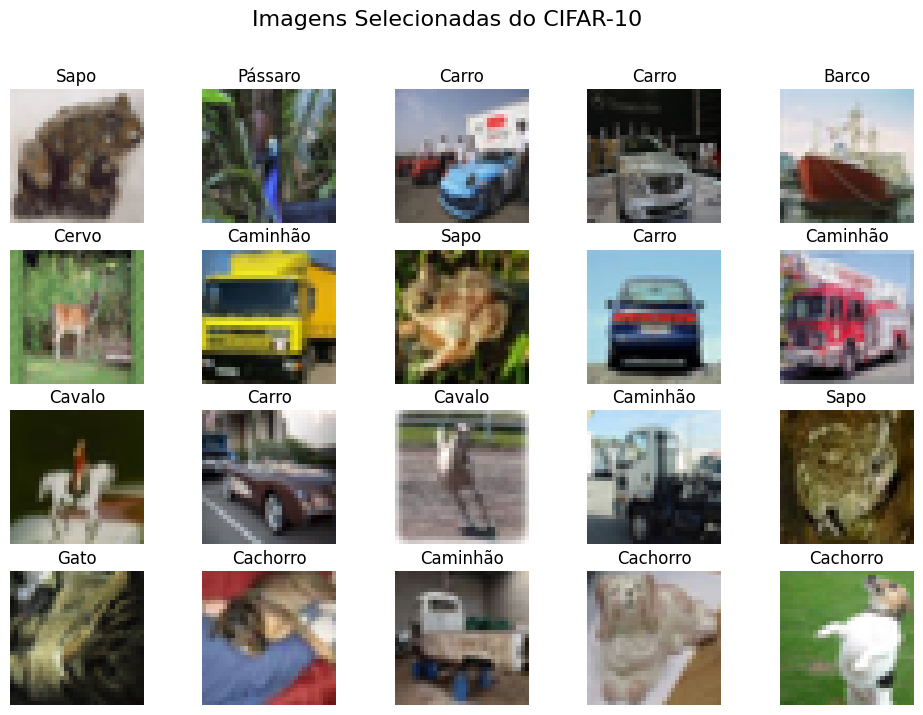

In [35]:
!pip install tensorflow > /dev/null
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tabulate import tabulate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model
from sklearn.model_selection import train_test_split

# Carregando os valores do CIFAR-10
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Reduzindo a quantidade de pixels
x_train, x_test = x_train / 255.0, x_test / 255.0

# Transformando os rótulos em uma dimensão
y_train, y_test = y_train.flatten(), y_test.flatten()

# Definindo as classes do CIFAR-10
nome_classes = ['Avião', 'Carro', 'Pássaro', 'Gato', 'Cervo', 'Cachorro', 'Sapo', 'Cavalo', 'Barco', 'Caminhão']

# Selecionando 20 imagens aleatórias do conjunto de treinamento para visualização
num_imagens_visualizacao = 20
indices_selecionados = np.random.choice(len(x_train), num_imagens_visualizacao, replace=False)
imagens_selecionadas = x_train[indices_selecionados]
rotulos_selecionados = y_train[indices_selecionados]

# Visualizando as imagens selecionadas
plt.figure(figsize=(12, 8))
for i in range(num_imagens_visualizacao):
    plt.subplot(4, 5, i+1)
    plt.imshow(imagens_selecionadas[i])
    plt.title(nome_classes[rotulos_selecionados[i]])
    plt.axis('off')
plt.suptitle("Imagens Selecionadas do CIFAR-10", fontsize=16)
plt.show()

#**Preparação de Dados**:
Nessa etapa, o código realiza a separação dos dados em conjuntos de treino e teste, bem como aplica um método de data augmentation nas imagens de treinamento selecionadas. A normalização dos pixels é feita dividindo os valores por 255.0, e os rótulos do conjunto de teste são convertidos em one-hot encoding. Além disso, é realizada uma visualização de 20 imagens selecionadas aleatoriamente do conjunto de treinamento.

In [34]:
# Reduzindo a quantidade de pixels
x_train, x_test = x_train / 255.0, x_test / 255.0

# Transformando os rótulos em uma dimensão
y_train, y_test = y_train.flatten(), y_test.flatten()

# Etapa 2 (continuação)
# Criação do conjunto de validação
validation_split = 0.2
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_split, random_state=42)

# Aplicando data augmentation nas imagens de treinamento selecionadas
batch_size = 4
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

data_generator.fit(x_train)
train_generator = data_generator.flow(x_train, y_train, batch_size=batch_size)
steps_per_epoch = len(x_train) // batch_size

# Definir o número de classes (número de rótulos válidos)
num_classes = len(set(y_train))

# Convertendo os rótulos do conjunto de teste para categorias one-hot
y_test_onehot = tf.one_hot(y_test, depth=num_classes, dtype=tf.float32)

# Filtrando as amostras com rótulos inválidos no conjunto de teste
indices_teste_valido = np.where(y_test < num_classes)[0]
x_test_valido = x_test[indices_teste_valido]
y_test_valido = y_test_onehot.numpy()[indices_teste_valido]

# Criando o modelo 0 (mantendo o código da etapa 1)
K = len(set(rotulos_selecionados))  # número de classes
num = 2
i = tf.keras.layers.Input(shape=x_treinamento_selecionado[0].shape)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(i)
# Resto do código do modelo 0...

# Compilando o modelo
model0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Verificando o tamanho dos conjuntos de treinamento, validação e teste
print("Tamanho do conjunto de treinamento:", len(x_train))
print("Tamanho do conjunto de validação:", len(x_validation))
print("Tamanho do conjunto de teste válido:", len(x_test_valido))

Tamanho do conjunto de treinamento: 40000
Tamanho do conjunto de validação: 10000
Tamanho do conjunto de teste válido: 10000


#**Modelagem e treinamento 1:**
Nessa etapa, é construído um modelo de CNN com algumas camadas convolucionais e de pooling. O modelo é compilado com otimizador "adam" e a função de perda "sparse_categorical_crossentropy". Em seguida, o modelo é treinado utilizando um conjunto de validação de 20% dos dados de teste válido, que foram filtrados para conter apenas rótulos válidos. A acurácia do modelo no conjunto de teste válido é calculada e exibida.

In [23]:
# Compilando o modelo
model0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Convertendo o conjunto de teste para um DataFrame do Pandas para facilitar a filtragem
df_teste = pd.DataFrame({'Imagem': np.arange(len(y_test)), 'Rotulo': y_test})

# Filtrando as amostras com rótulos inválidos no conjunto de teste
df_teste_valido = df_teste[df_teste['Rotulo'] < len(nome_classes)]

# Obtendo os índices das amostras válidas no conjunto de teste
indices_teste_valido = df_teste_valido['Imagem'].values

# Selecionando apenas as amostras válidas no conjunto de teste
x_test_valido = x_test[indices_teste_valido]
y_test_valido = y_test[indices_teste_valido]

# Fazendo as previsões para todo o conjunto de teste válido
previsoes = model0.predict(x_test_valido)

# Obtendo as classes previstas para o conjunto de teste válido
y_pred_classes = np.argmax(previsoes, axis=1)

# Avaliando o modelo nos dados de teste válidos
acuracia = np.mean(y_pred_classes == y_test_valido)
print(f'Acurácia no conjunto de teste: {acuracia*100:.2f}%')

# Preparando os dados para a tabela (mantendo a mesma parte do código anterior)
dados_tabela = []
for i in range(min(num_imagens_visualizacao, 16)):
    probabilidade_classe = previsoes[i]
    num_classes = len(probabilidade_classe)
    classe_prevista = np.argmax(probabilidade_classe)
    probabilidade_maxima = np.max(probabilidade_classe)
    dados_tabela.append([i + 1, nome_classes[classe_prevista], f'{probabilidade_maxima * 100:.2f}%'])

# Exibindo as previsões em forma de tabela usando tabulate
print("\nPrevisões do Modelo para as Imagens de Teste:")
print(tabulate(dados_tabela, headers=["Imagem", "Classe Prevista", "Probabilidade"]))

313/313 [==============================] - 49s 156ms/step
Acurácia no conjunto de teste: 10.00%

Previsões do Modelo para as Imagens de Teste:
  Imagem  Classe Prevista    Probabilidade
--------  -----------------  ---------------
       1  Sapo               10.63%
       2  Sapo               10.94%
       3  Sapo               10.82%
       4  Sapo               10.93%
       5  Sapo               10.50%
       6  Sapo               10.59%
       7  Sapo               10.54%
       8  Sapo               10.52%
       9  Sapo               10.68%
      10  Sapo               10.77%
      11  Sapo               10.78%
      12  Sapo               10.80%
      13  Sapo               10.52%
      14  Sapo               10.78%
      15  Sapo               10.75%
      16  Sapo               10.85%


#**Modelagem e treinamento 2**:
Essa etapa treina novamente o modelo com o conjunto de teste válido, mas dessa vez coletando o histórico de treinamento e plotando a curva de aprendizado. A acurácia do modelo no conjunto de teste é exibida novamente.

Epoch 1/10
250/250 [==============================] - 139s 321ms/step - loss: 1.9019 - accuracy: 0.3761 - val_loss: 3.7264 - val_accuracy: 0.1545
Epoch 2/10
250/250 [==============================] - 76s 303ms/step - loss: 1.3965 - accuracy: 0.4965 - val_loss: 1.5928 - val_accuracy: 0.4400
Epoch 3/10
250/250 [==============================] - 75s 301ms/step - loss: 1.1973 - accuracy: 0.5649 - val_loss: 1.4101 - val_accuracy: 0.4885
Epoch 4/10
250/250 [==============================] - 74s 298ms/step - loss: 1.0261 - accuracy: 0.6300 - val_loss: 1.2480 - val_accuracy: 0.5640
Epoch 5/10
250/250 [==============================] - 76s 304ms/step - loss: 0.8705 - accuracy: 0.6846 - val_loss: 1.1417 - val_accuracy: 0.6090
Epoch 6/10
250/250 [==============================] - 75s 300ms/step - loss: 0.7386 - accuracy: 0.7356 - val_loss: 1.0873 - val_accuracy: 0.6340
Epoch 7/10
250/250 [==============================] - 76s 303ms/step - loss: 0.6228 - accuracy: 0.7760 - val_loss: 1.2187 - val_a

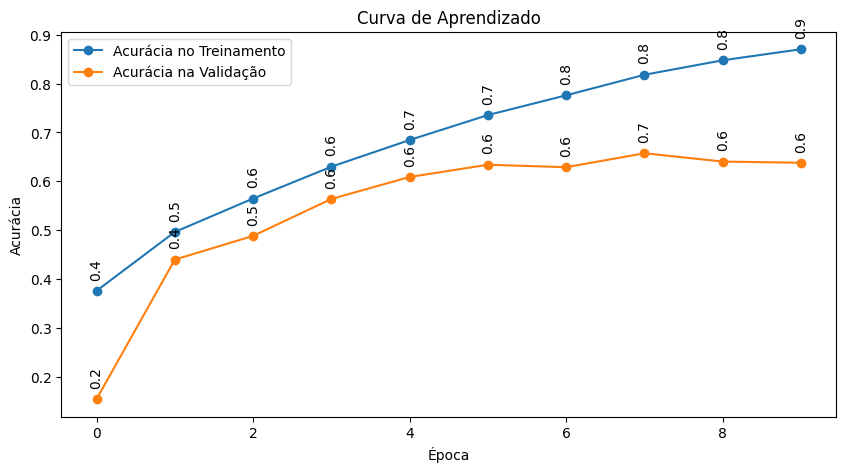

In [25]:
# Compilando o modelo
model0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinando o modelo e coletando o histórico
history = model0.fit(x_test_valido, y_test_valido, epochs=10, batch_size=32, validation_split=0.2)

# Avaliando o modelo nos dados de teste
score = model0.evaluate(x_test_valido, y_test_valido, verbose=0)
print(f'Acurácia no conjunto de teste: {score[1]*100:.2f}%')

# Visualizando a curva de aprendizado
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Acurácia no Treinamento', marker='o')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação', marker='o')
plt.title('Curva de Aprendizado')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Adicionando rótulos de dados nas linhas
for i in range(len(history.history['accuracy'])):
    plt.annotate(f"{history.history['accuracy'][i]:.1f}", (i, history.history['accuracy'][i]), textcoords="offset points", xytext=(0,10), ha='center', rotation=90)
    plt.annotate(f"{history.history['val_accuracy'][i]:.1f}", (i, history.history['val_accuracy'][i]), textcoords="offset points", xytext=(0,10), ha='center', rotation=90)

plt.show()

#**Avaliação de Resultados**:
Nessa etapa, o modelo é avaliado em um conjunto de imagens de teste diferentes daquele utilizado no treinamento. As previsões são exibidas em um conjunto de 8 imagens selecionadas aleatoriamente, juntamente com a classe real correspondente.

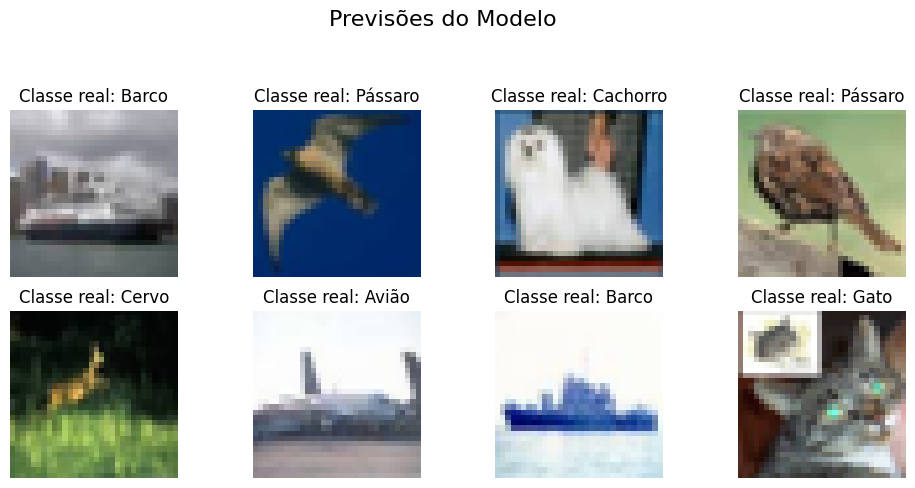

In [28]:
#Etapa 6
# Visualizando as previsões do modelo em algumas imagens de teste
num_imagens_visualizacao = 8
indices_selecionados_teste = np.random.choice(len(x_test), num_imagens_visualizacao, replace=False)
imagens_teste_selecionadas = x_test[indices_selecionados_teste]
rotulos_teste_selecionados = y_test[indices_selecionados_teste]

plt.figure(figsize=(12, 10))
for i in range(num_imagens_visualizacao):
    plt.subplot(4, 4, i+1)
    plt.imshow(imagens_teste_selecionadas[i])
    plt.title(f'Classe real: {nome_classes[rotulos_teste_selecionados[i]]}')
    plt.axis('off')
plt.suptitle("Previsões do Modelo", fontsize=16)
plt.show()

#**Avaliação de Resultados**:
Nessa etapa, o modelo é novamente avaliado no conjunto de teste original e as previsões são exibidas para algumas imagens de teste selecionadas aleatoriamente.

313/313 [==============================] - 22s 69ms/step


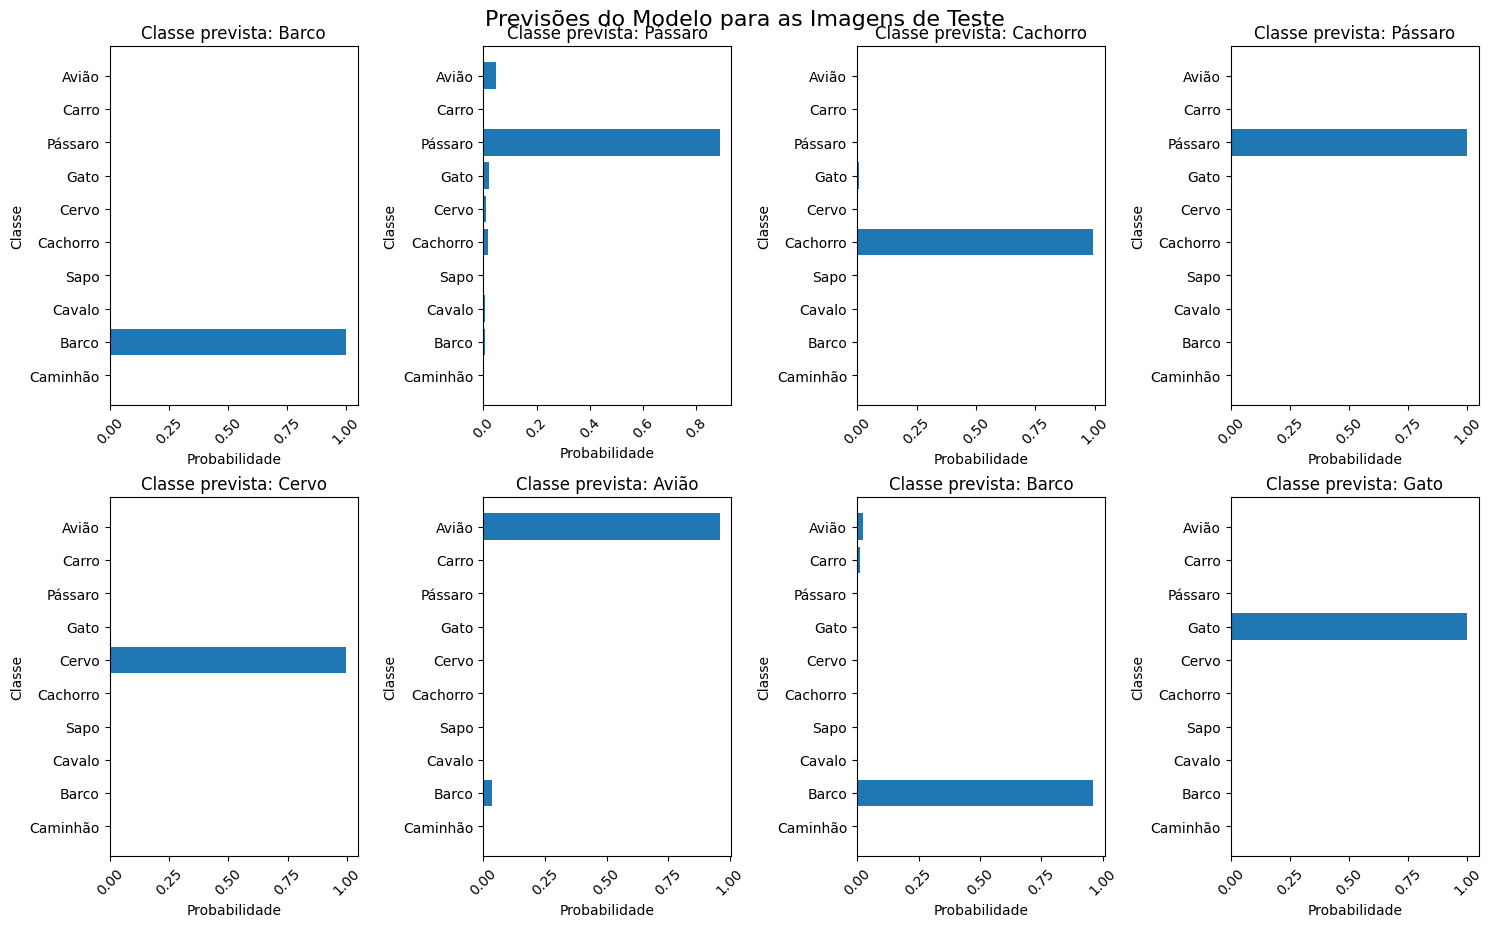

In [31]:
# Fazendo as previsões para todo o conjunto de teste
previsoes = model0.predict(x_test)

# Exibindo os gráficos das previsões para cada imagem de teste selecionada
plt.figure(figsize=(15, 18))
for i in range(num_imagens_visualizacao):
    plt.subplot(4, 4, i + 1)
    indice = indices_selecionados_teste[i]
    plt.barh(range(K), previsoes[indice], tick_label=nome_classes)
    plt.xlabel('Probabilidade')
    plt.ylabel('Classe')
    classe_prevista = nome_classes[np.argmax(previsoes[indice])]
    plt.title(f'Classe prevista: {classe_prevista}')
    plt.xticks(rotation=45)
    plt.gca().invert_yaxis()  # Inverte a ordem das classes no eixo y
plt.suptitle("Previsões do Modelo para as Imagens de Teste", fontsize=16)
plt.tight_layout()
plt.show()

**Obs:** Observe que a acurácia pode variar ligeiramente nas duas avaliações devido a algumas aleatoriedades (por exemplo, escolha aleatória de amostras de teste selecionadas e a divisão de validação no treinamento).